In [0]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import math, os

In [0]:
# Define some handy network layers
def lrelu(x, rate=0.1):
    return tf.maximum(tf.minimum(x * rate, 0), x)

def conv2d_lrelu(inputs, num_outputs, kernel_size, stride):
    conv = tf.contrib.layers.convolution2d(inputs, num_outputs, kernel_size, stride, 
                                           weights_initializer=tf.contrib.layers.xavier_initializer(),
                                           activation_fn=tf.identity)
    conv = lrelu(conv)
    return conv

def conv2d_t_relu(inputs, num_outputs, kernel_size, stride):
    conv = tf.contrib.layers.convolution2d_transpose(inputs, num_outputs, kernel_size, stride,
                                                     weights_initializer=tf.contrib.layers.xavier_initializer(),
                                                     activation_fn=tf.identity)
    conv = tf.nn.relu(conv)
    return conv

def fc_lrelu(inputs, num_outputs):
    fc = tf.contrib.layers.fully_connected(inputs, num_outputs,
                                           weights_initializer=tf.contrib.layers.xavier_initializer(),
                                           activation_fn=tf.identity)
    fc = lrelu(fc)
    return fc

def fc_relu(inputs, num_outputs):
    fc = tf.contrib.layers.fully_connected(inputs, num_outputs,
                                           weights_initializer=tf.contrib.layers.xavier_initializer(),
                                           activation_fn=tf.identity)
    fc = tf.nn.relu(fc)
    return fc

In [0]:
# Encoder and decoder use the DC-GAN architecture
def encoder(x, z_dim):
    with tf.variable_scope('encoder'):
        conv1 = conv2d_lrelu(x, 64, 4, 2)
        conv2 = conv2d_lrelu(conv1, 128, 4, 2)
        conv2 = tf.reshape(conv2, [-1, np.prod(conv2.get_shape().as_list()[1:])])
        fc1 = fc_lrelu(conv2, 1024)
        return tf.contrib.layers.fully_connected(fc1, z_dim, activation_fn=tf.identity)

In [0]:
def decoder(z, reuse=False):
    with tf.variable_scope('decoder') as vs:
        if reuse:
            vs.reuse_variables()
        fc1 = fc_relu(z, 1024)
        fc2 = fc_relu(fc1, 7*7*128)
        fc2 = tf.reshape(fc2, tf.stack([tf.shape(fc2)[0], 7, 7, 128]))
        conv1 = conv2d_t_relu(fc2, 64, 4, 2)
        output = tf.contrib.layers.convolution2d_transpose(conv1, 1, 4, 2, activation_fn=tf.sigmoid)
        return output

In [0]:
# Build the computation graph for training
z_dim = 20
train_x = tf.placeholder(tf.float32, shape=[None, 28, 28, 1])
train_z = encoder(train_x, z_dim)
train_xr = decoder(train_z)

W0721 09:05:34.155797 139973676341120 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [0]:
# Build the computation graph for generating samples
gen_z = tf.placeholder(tf.float32, shape=[None, z_dim])
gen_x = decoder(gen_z, reuse=True)

In [0]:
def compute_kernel(x, y):
    x_size = tf.shape(x)[0]
    y_size = tf.shape(y)[0]
    dim = tf.shape(x)[1]
    tiled_x = tf.tile(tf.reshape(x, tf.stack([x_size, 1, dim])), tf.stack([1, y_size, 1]))
    tiled_y = tf.tile(tf.reshape(y, tf.stack([1, y_size, dim])), tf.stack([x_size, 1, 1]))
    return tf.exp(-tf.reduce_mean(tf.square(tiled_x - tiled_y), axis=2) / tf.cast(dim, tf.float32))

def compute_mmd(x, y):
    x_kernel = compute_kernel(x, x)
    y_kernel = compute_kernel(y, y)
    xy_kernel = compute_kernel(x, y)
    return tf.reduce_mean(x_kernel) + tf.reduce_mean(y_kernel) - 2 * tf.reduce_mean(xy_kernel)

In [0]:
# Compare the generated z with true samples from a standard Gaussian, and compute their MMD distance
true_samples = tf.random_normal(tf.stack([200, z_dim]))
loss_mmd = compute_mmd(true_samples, train_z)

In [0]:
loss_nll = tf.reduce_mean(tf.square(train_xr - train_x))
loss = loss_nll + loss_mmd
trainer = tf.train.AdamOptimizer(1e-3).minimize(loss)

W0721 09:05:36.207656 139973676341120 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('mnist_data')

W0721 09:05:36.600197 139973676341120 deprecation.py:323] From <ipython-input-10-3358d3e207c9>:2: read_data_sets (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
W0721 09:05:36.604506 139973676341120 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:260: maybe_download (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed in a future version.
Instructions for updating:
Please write your own downloading logic.
W0721 09:05:36.610090 139973676341120 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/base.py:252: _internal_retry.<locals>.wrap.<locals>.wrapped_fn (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be remove

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting mnist_data/train-images-idx3-ubyte.gz


W0721 09:05:37.607078 139973676341120 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:267: extract_labels (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.data to implement this functionality.


Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting mnist_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting mnist_data/t10k-images-idx3-ubyte.gz


W0721 09:05:37.957523 139973676341120 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:290: DataSet.__init__ (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting mnist_data/t10k-labels-idx1-ubyte.gz


In [0]:
# Convert a numpy array of shape [batch_size, height, width, 1] into a displayable array 
# of shape [height*sqrt(batch_size, width*sqrt(batch_size))] by tiling the images
def convert_to_display(samples):
    cnt, height, width = int(math.floor(math.sqrt(samples.shape[0]))), samples.shape[1], samples.shape[2]
    samples = np.transpose(samples, axes=[1, 0, 2, 3])
    samples = np.reshape(samples, [height, cnt, cnt, width])
    samples = np.transpose(samples, axes=[1, 0, 2, 3])
    samples = np.reshape(samples, [height*cnt, width*cnt])
    return samples

In [0]:
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
batch_size = 200
sess = tf.Session()
sess.run(tf.global_variables_initializer())

Negative log likelihood is 0.009275, mmd loss is 0.001123


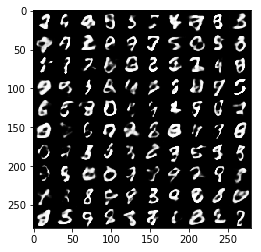

Negative log likelihood is 0.008786, mmd loss is 0.001334
Negative log likelihood is 0.007917, mmd loss is 0.001056
Negative log likelihood is 0.006628, mmd loss is 0.001885
Negative log likelihood is 0.006932, mmd loss is 0.000774


In [0]:
# Start training
for i in range(500):
    batch_x, batch_y = mnist.train.next_batch(batch_size)
    batch_x = batch_x.reshape(-1, 28, 28, 1)
    _, nll, mmd = sess.run([trainer, loss_nll, loss_mmd], feed_dict={train_x: batch_x})
    if i % 100 == 0:
        print("Negative log likelihood is %f, mmd loss is %f" % (nll, mmd))
    if i % 500 == 0:
        samples = sess.run(gen_x, feed_dict={gen_z: np.random.normal(size=(100, z_dim))})
        plt.imshow(convert_to_display(samples), cmap='Greys_r')
        plt.show()